DATASET CLEANING AND INTERPOLATION

In [30]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d

In [31]:
df = pd.read_csv("MasterDataset.csv")

df = df.drop(columns=['snow','snwd']) # drop snow and snwd

df["month"] = pd.to_datetime(df["month"], format="%Y-%m").dt.to_period("M")

df["year"] = df["month"].dt.year
df["month_num"] = df["month"].dt.month

# fill dates from Jan 2018 and Jul 2025
states = sorted(df["state"].unique())
all_months = pd.period_range("2018-01", "2025-07", freq="M") 

base_panel = (
    pd.MultiIndex.from_product([states, all_months], names=["state", "month"])
    .to_frame(index=False)
)

# mering
full = base_panel.merge(
    df,
    on=["state", "month"],
    how="left",
    indicator=True
)

# 6. Mark which rows were originally present
full["observed"] = full["_merge"].eq("both")
full.drop(columns="_merge", inplace=True)


#sort
full = full.sort_values(["state", "month"]).reset_index(drop=True)

full.to_csv("MasterDataset_2018_2025_fullpanel.csv", index=False)
print(full.shape)
print(full.head())


(4550, 37)
     state    month     vmt      ndvi  flights   co_mean  co_max1_value  \
0  Alabama  2018-01  5101.0  0.552518   6819.0  0.270312       0.527258   
1  Alabama  2018-02  4975.0  0.541536   6417.0  0.219343       0.402143   
2  Alabama  2018-03  5952.0  0.565882   7507.0  0.226716       0.407704   
3  Alabama  2018-04  6145.0  0.679999   7541.0  0.214604       0.392311   
4  Alabama  2018-05  6253.0  0.761965   8002.0  0.302609       0.490366   

   co_max1_hour    co_aqi   no2_mean  ...  o3_max1_hour     o3_aqi      awnd  \
0     10.153226  5.209677  12.320599  ...     11.854839  30.725806  3.119355   
1     10.383929  3.946429   8.593592  ...     21.219246  22.709325  3.514286   
2      8.952151  3.747312   9.844573  ...     10.468993  40.165997  3.558065   
3      8.936111  3.705556   8.937356  ...     10.388948  45.017963  3.526667   
4      9.212366  4.946237  11.115237  ...      9.495067  45.172110  2.141935   

    prcp       tavg       tmax       tmin  year  month_nu

In [32]:
# # Count how many months are actually populated per state-year in the full panel
# month_counts = (
#     full.groupby(["state", "year"])["month"]
#         .nunique()
#         .reset_index(name="n_months")
# )
full = full.sort_values(["state", "month"])

numeric_cols = full.select_dtypes(include=["float64", "int64"]).columns.tolist()
for drop_col in ["year", "month_num", "month"]:
    if drop_col in numeric_cols:
        numeric_cols.remove(drop_col)

# polynomial interpolation per state w degree 2
full[numeric_cols] = full.groupby("state")[numeric_cols].transform(
    lambda g: g.interpolate(method="polynomial", order=2)
)

full[numeric_cols] = full.groupby("state")[numeric_cols].transform(
    lambda g: g.ffill().bfill()
)

print(full[numeric_cols].isnull().sum().sum())

full.to_csv("MasterDataset_interpolated.csv", index=False)


1820


In [33]:
## to fill the 1820 (they're fully missing so interpolation won't work
#print(full.isna().sum())

# Groups of columns that still have NA
cols_no2 = ["no2_mean", "no2_max1_value", "no2_max1_hour", "no2_aqi"]
cols_pm10 = ["pm10_mean", "pm10_max1_value", "pm10_max1_hour", "pm10_aqi"]
cols_tavg = ["tavg"]

# For each month, fill remaining NAs with monthly mean
for cols in [cols_no2, cols_pm10, cols_tavg]:
    for col in cols:
        full[col] = full.groupby("month")[col].transform(
            lambda s: s.fillna(s.mean())
        )

print("Total remaining NAs:", full.isna().sum().sum())
print(full[cols_no2 + cols_pm10 + cols_tavg].isna().sum())

#
full.to_csv("MasterDataset_interpolated_final.csv", index=False)

Total remaining NAs: 0
no2_mean           0
no2_max1_value     0
no2_max1_hour      0
no2_aqi            0
pm10_mean          0
pm10_max1_value    0
pm10_max1_hour     0
pm10_aqi           0
tavg               0
dtype: int64


SARIMAX

In [34]:
## MODEL 
df = full.copy() 

df["month"] = pd.to_datetime(df["month"].astype(str))

df = df.sort_values(["state", "month"]).reset_index(drop=True)

from sklearn.preprocessing import StandardScaler
continuous_cols = [
    'vmt','ndvi','flights',
    'co_mean','co_max1_value','co_max1_hour','co_aqi',
    'no2_mean','no2_max1_value','no2_max1_hour','no2_aqi',
    'pm25_max1_value','pm25_max1_hour','pm25_aqi',
    'pm10_mean','pm10_max1_value','pm10_max1_hour','pm10_aqi',
    'so2_mean','so2_max1_value','so2_max1_hour','so2_aqi',
    'o3_mean','o3_max1_value','o3_max1_hour','o3_aqi',
    'awnd','prcp','tavg','tmax','tmin'
] 
feature_cols = continuous_cols + ['month_num']

target_col = "pm25_mean"   # or whichever target you are predicting

print("len(feature_cols):", len(feature_cols))
print(feature_cols)

## train test split
# 1. Time splits (after df["month"] is datetime and df sorted)
train_end = pd.Period("2021-12", freq="M")
val_end   = pd.Period("2023-12", freq="M")

train_end = train_end.to_timestamp() #Added
val_end   = val_end.to_timestamp() #Added

train_df = df[df["month"] <= train_end]
val_df   = df[(df["month"] > train_end) & (df["month"] <= val_end)]
test_df  = df[df["month"] > val_end]

print("Train:", train_df["month"].min(), "->", train_df["month"].max())
print("Val:  ", val_df["month"].min(),   "->", val_df["month"].max())
print("Test: ", test_df["month"].min(),  "->", test_df["month"].max())

scaler = StandardScaler().fit(train_df[feature_cols])

def apply_scaler(local_df):
    d = local_df.copy()
    d[feature_cols] = scaler.transform(d[feature_cols].values)
    return d

# 2. Scale features
train_df_s = apply_scaler(train_df)
val_df_s   = apply_scaler(val_df)
test_df_s  = apply_scaler(test_df)

# 3.Build sequences
seq_len = 12
def build_sequences(df, seq_len, feature_cols, target_col):
    sequences_X, sequences_y = [], []
    states_list = []
    
    for state in df['state'].unique():
        state_data = df[df['state'] == state].sort_values('month')
        state_features = state_data[feature_cols].values
        state_target = state_data[target_col].values
        
        for i in range(len(state_data) - seq_len):
            sequences_X.append(state_features[i:(i + seq_len)])
            sequences_y.append(state_target[i + seq_len])

            states_list.append(state) #added
    
    return np.array(sequences_X), np.array(sequences_y), np.array(states_list)

train_X, train_y, train_states = build_sequences(train_df_s, seq_len, feature_cols, target_col)
val_X,   val_y, val_states   = build_sequences(val_df_s,   seq_len, feature_cols, target_col)
test_X,  test_y, test_states  = build_sequences(test_df_s,  seq_len, feature_cols, target_col)

print("train_X:", train_X.shape)
print("train_y:", train_y.shape)
print("val_X:",   val_X.shape)
print("val_y:",   val_y.shape)
print("test_X:",  test_X.shape)
print("test_y:",  test_y.shape)

len(feature_cols): 32
['vmt', 'ndvi', 'flights', 'co_mean', 'co_max1_value', 'co_max1_hour', 'co_aqi', 'no2_mean', 'no2_max1_value', 'no2_max1_hour', 'no2_aqi', 'pm25_max1_value', 'pm25_max1_hour', 'pm25_aqi', 'pm10_mean', 'pm10_max1_value', 'pm10_max1_hour', 'pm10_aqi', 'so2_mean', 'so2_max1_value', 'so2_max1_hour', 'so2_aqi', 'o3_mean', 'o3_max1_value', 'o3_max1_hour', 'o3_aqi', 'awnd', 'prcp', 'tavg', 'tmax', 'tmin', 'month_num']
Train: 2018-01-01 00:00:00 -> 2021-12-01 00:00:00
Val:   2022-01-01 00:00:00 -> 2023-12-01 00:00:00
Test:  2024-01-01 00:00:00 -> 2025-07-01 00:00:00
train_X: (1800, 12, 32)
train_y: (1800,)
val_X: (600, 12, 32)
val_y: (600,)
test_X: (350, 12, 32)
test_y: (350,)


/Users/malarmuthu/conda/envs/dva_env/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/malarmuthu/conda/envs/dva_env/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/malarmuthu/conda/envs/dva_env/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [38]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Exogenous features: all numeric columns except the target and state
exog_cols = [
    col for col in df.select_dtypes(include=["float64", "int64"]).columns
    if col not in [target_col, "state"]
]
print("Exogenous features:", exog_cols)

all_true_values = []
all_predicted_values = []
all_states_for_rows = []

states = sorted(df["state"].unique())

for state_name in states:
    g_train = train_df_s[train_df_s['state'] == state_name].sort_values('month')
    g_val   = val_df_s[val_df_s['state'] == state_name].sort_values('month')

    if len(g_train) < 24 or len(g_val) == 0:
        print(f"Skipping {state_name}: not enough data")
        continue

    g_train = g_train.reset_index(drop=True)
    g_val   = g_val.reset_index(drop=True)

    endog_train = g_train[target_col]
    endog_val   = g_val[target_col]

    exog_train = g_train[exog_cols]
    exog_val   = g_val[exog_cols]

    try:
        model = SARIMAX(
            endog=endog_train,
            exog=exog_train,
            order=(1, 1, 1),
            seasonal_order=(1, 1, 1, 12),  
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        res = model.fit(disp=False)

        fc = res.get_forecast(steps=len(g_val), exog=exog_val)
        sarimax_pred = fc.predicted_mean  

        val_states = np.repeat(state_name, len(sarimax_pred))

        all_true_values.extend(endog_val.values.flatten())
        all_predicted_values.extend(sarimax_pred.values.flatten())
        all_states_for_rows.extend(val_states)

    except Exception as e:
        print(f"Error for {state_name}: {e}")


Exogenous features: ['vmt', 'ndvi', 'flights', 'co_mean', 'co_max1_value', 'co_max1_hour', 'co_aqi', 'no2_mean', 'no2_max1_value', 'no2_max1_hour', 'no2_aqi', 'pm25_max1_value', 'pm25_max1_hour', 'pm25_aqi', 'pm10_mean', 'pm10_max1_value', 'pm10_max1_hour', 'pm10_aqi', 'so2_mean', 'so2_max1_value', 'so2_max1_hour', 'so2_aqi', 'o3_mean', 'o3_max1_value', 'o3_max1_hour', 'o3_aqi', 'awnd', 'prcp', 'tavg', 'tmax', 'tmin', 'year', 'month_num']


/Users/malarmuthu/conda/envs/dva_env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/malarmuthu/conda/envs/dva_env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/malarmuthu/conda/envs/dva_env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/malarmuthu/conda/envs/dva_env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maxim

In [40]:
df_val_results = pd.DataFrame({
    "state": all_states_for_rows,
    "y_true": all_true_values,
    "y_pred": all_predicted_values
})

sarimax_metrics = df_val_results.groupby("state").apply(
    lambda g: pd.Series({
        "MAE": mean_absolute_error(g["y_true"], g["y_pred"]),
        "RMSE": np.sqrt(mean_squared_error(g["y_true"], g["y_pred"])),
        "N_samples": len(g)
    })
).reset_index()

print("\nPer-state SARIMAX performance:")
print(sarimax_metrics)

# 8. Overall baseline metrics across all states
overall_mae  = sarimax_metrics["MAE"].mean()
overall_rmse = sarimax_metrics["RMSE"].mean()

print("\nSARIMAX baseline – average over states:")
print("MAE (µg/m³):", overall_mae)
print("RMSE (µg/m³):", overall_rmse)



Per-state SARIMAX performance:
             state        MAE       RMSE  N_samples
0          Alabama   0.224426   0.278079       24.0
1           Alaska   2.264178   2.745977       24.0
2          Arizona   0.876999   1.013018       24.0
3         Arkansas   0.106691   0.150089       24.0
4       California   0.982590   1.267200       24.0
5         Colorado   3.880598   6.113658       24.0
6      Connecticut   0.708042   1.134380       24.0
7         Delaware   1.051154   1.236972       24.0
8          Florida   0.363618   0.445406       24.0
9          Georgia   0.991147   1.202139       24.0
10          Hawaii   0.431297   0.524376       24.0
11           Idaho   0.692787   0.898071       24.0
12        Illinois   0.780401   0.983369       24.0
13         Indiana   0.876354   1.326799       24.0
14            Iowa   2.182711   2.731966       24.0
15          Kansas   2.042676   2.724538       24.0
16        Kentucky   1.711962   1.988200       24.0
17       Louisiana   0.230969   

LSTM

In [53]:
## MODEL 
df = full.copy() 

df["month"] = pd.to_datetime(df["month"].astype(str))

df = df.sort_values(["state", "month"]).reset_index(drop=True)

# 2. Cyclical month features (seasonality)
#df["month_sin"] = np.sin(2 * np.pi * df["month_num"] / 12)
#df["month_cos"] = np.cos(2 * np.pi * df["month_num"] / 12)

# 3. One-hot encoding state (global model over all states)
#state_dummies = pd.get_dummies(df["state"], prefix="state")
#df = pd.concat([df, state_dummies], axis=1)

from sklearn.preprocessing import StandardScaler
continuous_cols = [
    'vmt','ndvi','flights',
    'co_mean','co_max1_value','co_max1_hour','co_aqi',
    'no2_mean','no2_max1_value','no2_max1_hour','no2_aqi',
    'pm25_max1_value','pm25_max1_hour','pm25_aqi',
    'pm10_mean','pm10_max1_value','pm10_max1_hour','pm10_aqi',
    'so2_mean','so2_max1_value','so2_max1_hour','so2_aqi',
    'o3_mean','o3_max1_value','o3_max1_hour','o3_aqi',
    'awnd','prcp','tavg','tmax','tmin'
] 
feature_cols = continuous_cols + ['month_num']

target_col = "pm25_mean"   # or whichever target you are predicting

print("len(feature_cols):", len(feature_cols))
print(feature_cols)

## train test split
# 1. Time splits (after df["month"] is datetime and df sorted)
train_end = pd.Period("2021-12", freq="M")
val_end   = pd.Period("2023-12", freq="M")

train_end = train_end.to_timestamp() #Added
val_end   = val_end.to_timestamp() #Added

train_df = df[df["month"] <= train_end]
val_df   = df[(df["month"] > train_end) & (df["month"] <= val_end)]
test_df  = df[df["month"] > val_end]

print("Train:", train_df["month"].min(), "->", train_df["month"].max())
print("Val:  ", val_df["month"].min(),   "->", val_df["month"].max())
print("Test: ", test_df["month"].min(),  "->", test_df["month"].max())

scaler = StandardScaler().fit(train_df[feature_cols])

def apply_scaler(local_df):
    d = local_df.copy()
    d[feature_cols] = scaler.transform(d[feature_cols].values)
    return d

# 2. Scale features
train_df_s = apply_scaler(train_df)
val_df_s   = apply_scaler(val_df)
test_df_s  = apply_scaler(test_df)

len(feature_cols): 32
['vmt', 'ndvi', 'flights', 'co_mean', 'co_max1_value', 'co_max1_hour', 'co_aqi', 'no2_mean', 'no2_max1_value', 'no2_max1_hour', 'no2_aqi', 'pm25_max1_value', 'pm25_max1_hour', 'pm25_aqi', 'pm10_mean', 'pm10_max1_value', 'pm10_max1_hour', 'pm10_aqi', 'so2_mean', 'so2_max1_value', 'so2_max1_hour', 'so2_aqi', 'o3_mean', 'o3_max1_value', 'o3_max1_hour', 'o3_aqi', 'awnd', 'prcp', 'tavg', 'tmax', 'tmin', 'month_num']
Train: 2018-01-01 00:00:00 -> 2021-12-01 00:00:00
Val:   2022-01-01 00:00:00 -> 2023-12-01 00:00:00
Test:  2024-01-01 00:00:00 -> 2025-07-01 00:00:00


/Users/malarmuthu/conda/envs/dva_env/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/malarmuthu/conda/envs/dva_env/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/malarmuthu/conda/envs/dva_env/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [54]:
# 3.Build sequences
seq_len = 12
def build_sequences(df, seq_len, feature_cols, target_col):
    sequences_X, sequences_y = [], []
    states_list = [] #added
    
    for state in df['state'].unique():
        state_data = df[df['state'] == state].sort_values('month')
        state_features = state_data[feature_cols].values
        state_target = state_data[target_col].values
        
        for i in range(len(state_data) - seq_len):
            sequences_X.append(state_features[i:(i + seq_len)])
            sequences_y.append(state_target[i + seq_len])

            states_list.append(state) #added
    
    return np.array(sequences_X), np.array(sequences_y), np.array(states_list)

train_X, train_y, train_states = build_sequences(train_df_s, seq_len, feature_cols, target_col)
val_X,   val_y, val_states   = build_sequences(val_df_s,   seq_len, feature_cols, target_col)
test_X,  test_y, test_states  = build_sequences(test_df_s,  seq_len, feature_cols, target_col)

print("train_X:", train_X.shape)
print("train_y:", train_y.shape)
print("val_X:",   val_X.shape)
print("val_y:",   val_y.shape)
print("test_X:",  test_X.shape)
print("test_y:",  test_y.shape)

train_X: (1800, 12, 32)
train_y: (1800,)
val_X: (600, 12, 32)
val_y: (600,)
test_X: (350, 12, 32)
test_y: (350,)


In [55]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

n_timesteps = train_X.shape[1]
n_features  = train_X.shape[2]

l2_reg = regularizers.l2(1e-4) #regularisation

model = models.Sequential([
    layers.Input(shape=(n_timesteps, n_features)),
    layers.LSTM(64, return_sequences=True,kernel_regularizer=l2_reg, recurrent_regularizer=l2_reg),
    layers.Dropout(0.2),
    layers.LSTM(32,return_sequences=False,kernel_regularizer=l2_reg,recurrent_regularizer=l2_reg),
    layers.Dropout(0.2),
    layers.Dense(32, activation="relu",kernel_regularizer=l2_reg),
    layers.Dense(32, activation="relu",kernel_regularizer=l2_reg),
    layers.Dense(16,activation="relu"),
    layers.Dense(1) 
])

model.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=["mae"]
)

model.summary()

## training
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=7,
    min_lr=1e-5
)

history = model.fit(
    train_X, train_y,
    validation_data=(val_X, val_y),
    epochs=150,
    batch_size=32,
    callbacks=[early_stop,reduce_lr],
    verbose=1
)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 12, 64)            24832     
                                                                 
 dropout_10 (Dropout)        (None, 12, 64)            0         
                                                                 
 lstm_9 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_11 (Dropout)        (None, 32)                0         
                                                                 
 dense_20 (Dense)            (None, 32)                1056      
                                                                 
 dense_21 (Dense)            (None, 32)                1056      
                                                                 
 dense_22 (Dense)            (None, 16)               

In [56]:
test_loss, test_mae = model.evaluate(test_X, test_y, verbose=0)
print("Test MSE:", test_loss)
print("Test MAE:", test_mae)

val_loss, val_mae = model.evaluate(val_X, val_y)
print("Validation MAE:", val_mae)

# Make predictions
val_pred  = model.predict(val_X)
test_pred = model.predict(test_X)

df_val_results = pd.DataFrame({
    "state": val_states,
    "y_true": val_y.flatten(),
    "y_pred": val_pred.flatten()
})

lstm_metrics = df_val_results.groupby("state").apply(
    lambda g: pd.Series({
        "MAE": mean_absolute_error(g["y_true"], g["y_pred"]),
        "RMSE": np.sqrt(mean_squared_error(g["y_true"], g["y_pred"])),
        "N_samples": len(g)
    })
).reset_index()


Test MSE: 2.4372243881225586
Test MAE: 1.223136067390442
19/19 [==============================] - 0s 1ms/step - loss: 9.9322 - mae: 1.7976
Validation MAE: 1.7975748777389526
11/11 [==============================] - 0s 977us/step


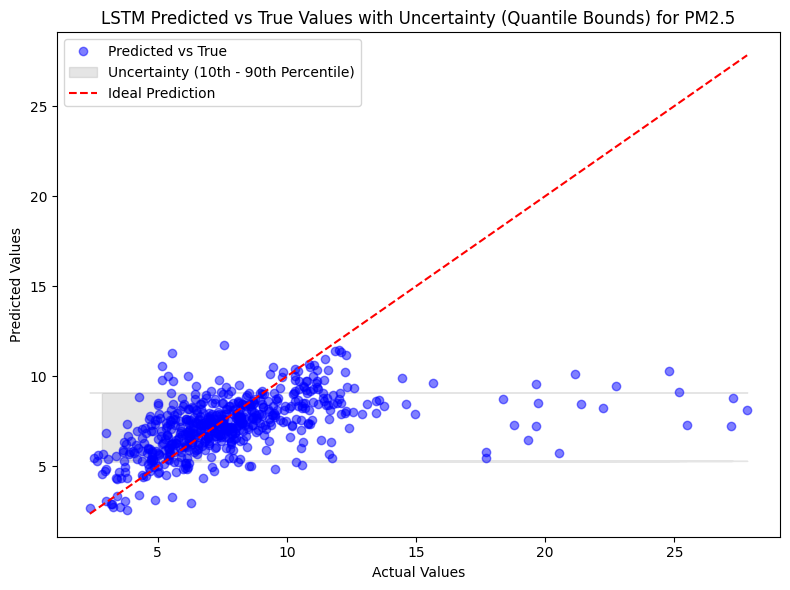

In [61]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

val_pred_flat = val_pred.flatten()
val_y_flat = val_y.flatten()

# Calculate the 10th and 90th percentiles of the predictions
lower_quantile = np.percentile(val_pred_flat, 10)
upper_quantile = np.percentile(val_pred_flat, 90)


plt.figure(figsize=(8, 6))
plt.plot(val_y_flat, val_pred_flat, 'bo', alpha=0.5, label='Predicted vs True')

plt.fill_between(val_y_flat, lower_quantile, upper_quantile, color='gray', alpha=0.2, label='Uncertainty (10th - 90th Percentile)')

plt.plot([min(val_y_flat), max(val_y_flat)], [min(val_y_flat), max(val_y_flat)], color='red', linestyle='--', label='Ideal Prediction')

# Set the labels and title
plt.title("LSTM Predicted vs True Values with Uncertainty (Quantile Bounds) for PM2.5")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()


GRU

In [45]:
## MODEL 
df = full.copy() 

df["month"] = pd.to_datetime(df["month"].astype(str))

df = df.sort_values(["state", "month"]).reset_index(drop=True)

# 2. Cyclical month features (seasonality)
#df["month_sin"] = np.sin(2 * np.pi * df["month_num"] / 12)
#df["month_cos"] = np.cos(2 * np.pi * df["month_num"] / 12)

# 3. One-hot encoding state (global model over all states)
#state_dummies = pd.get_dummies(df["state"], prefix="state")
#df = pd.concat([df, state_dummies], axis=1)

from sklearn.preprocessing import StandardScaler
continuous_cols = [
    'vmt','ndvi','flights',
    'co_mean','co_max1_value','co_max1_hour','co_aqi',
    'no2_mean','no2_max1_value','no2_max1_hour','no2_aqi',
    'pm25_max1_value','pm25_max1_hour','pm25_aqi',
    'pm10_mean','pm10_max1_value','pm10_max1_hour','pm10_aqi',
    'so2_mean','so2_max1_value','so2_max1_hour','so2_aqi',
    'o3_mean','o3_max1_value','o3_max1_hour','o3_aqi',
    'awnd','prcp','tavg','tmax','tmin'
] 
feature_cols = continuous_cols + ['month_num']

target_col = "pm25_mean"   # or whichever target you are predicting

print("len(feature_cols):", len(feature_cols))
print(feature_cols)

## train test split
# 1. Time splits (after df["month"] is datetime and df sorted)
train_end = pd.Period("2021-12", freq="M")
val_end   = pd.Period("2023-12", freq="M")

train_end = train_end.to_timestamp() #Added
val_end   = val_end.to_timestamp() #Added

train_df = df[df["month"] <= train_end]
val_df   = df[(df["month"] > train_end) & (df["month"] <= val_end)]
test_df  = df[df["month"] > val_end]

print("Train:", train_df["month"].min(), "->", train_df["month"].max())
print("Val:  ", val_df["month"].min(),   "->", val_df["month"].max())
print("Test: ", test_df["month"].min(),  "->", test_df["month"].max())

scaler = StandardScaler().fit(train_df[feature_cols])

def apply_scaler(local_df):
    d = local_df.copy()
    d[feature_cols] = scaler.transform(d[feature_cols].values)
    return d

# 2. Scale features
train_df_s = apply_scaler(train_df)
val_df_s   = apply_scaler(val_df)
test_df_s  = apply_scaler(test_df)

len(feature_cols): 32
['vmt', 'ndvi', 'flights', 'co_mean', 'co_max1_value', 'co_max1_hour', 'co_aqi', 'no2_mean', 'no2_max1_value', 'no2_max1_hour', 'no2_aqi', 'pm25_max1_value', 'pm25_max1_hour', 'pm25_aqi', 'pm10_mean', 'pm10_max1_value', 'pm10_max1_hour', 'pm10_aqi', 'so2_mean', 'so2_max1_value', 'so2_max1_hour', 'so2_aqi', 'o3_mean', 'o3_max1_value', 'o3_max1_hour', 'o3_aqi', 'awnd', 'prcp', 'tavg', 'tmax', 'tmin', 'month_num']
Train: 2018-01-01 00:00:00 -> 2021-12-01 00:00:00
Val:   2022-01-01 00:00:00 -> 2023-12-01 00:00:00
Test:  2024-01-01 00:00:00 -> 2025-07-01 00:00:00


/Users/malarmuthu/conda/envs/dva_env/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/malarmuthu/conda/envs/dva_env/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/malarmuthu/conda/envs/dva_env/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [46]:
# 3.Build sequences
seq_len = 12
def build_sequences(df, seq_len, feature_cols, target_col):
    sequences_X, sequences_y = [], []
    states_list = [] #added
    
    for state in df['state'].unique():
        state_data = df[df['state'] == state].sort_values('month')
        state_features = state_data[feature_cols].values
        state_target = state_data[target_col].values
        
        for i in range(len(state_data) - seq_len):
            sequences_X.append(state_features[i:(i + seq_len)])
            sequences_y.append(state_target[i + seq_len])

            states_list.append(state) #added
    
    return np.array(sequences_X), np.array(sequences_y), np.array(states_list)

train_X, train_y, train_states = build_sequences(train_df_s, seq_len, feature_cols, target_col)
val_X,   val_y, val_states   = build_sequences(val_df_s,   seq_len, feature_cols, target_col)
test_X,  test_y, test_states  = build_sequences(test_df_s,  seq_len, feature_cols, target_col)

print("train_X:", train_X.shape)
print("train_y:", train_y.shape)
print("val_X:",   val_X.shape)
print("val_y:",   val_y.shape)
print("test_X:",  test_X.shape)
print("test_y:",  test_y.shape)

train_X: (1800, 12, 32)
train_y: (1800,)
val_X: (600, 12, 32)
val_y: (600,)
test_X: (350, 12, 32)
test_y: (350,)


In [47]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

n_timesteps = train_X.shape[1]
n_features  = train_X.shape[2]

l2_reg = regularizers.l2(1e-4) #regularisation

model = models.Sequential([
    layers.Input(shape=(n_timesteps, n_features)),
    layers.GRU(64, return_sequences=True,kernel_regularizer=l2_reg, recurrent_regularizer=l2_reg),
    layers.Dropout(0.2),
    layers.GRU(32,return_sequences=False,kernel_regularizer=l2_reg,recurrent_regularizer=l2_reg),
    layers.Dropout(0.2),
    layers.Dense(32, activation="relu",kernel_regularizer=l2_reg),
    layers.Dense(32, activation="relu",kernel_regularizer=l2_reg),
    layers.Dense(16,activation="relu"),
    layers.Dense(1) 
])

model.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=["mae"]
)

model.summary()

## training
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=7,
    min_lr=1e-5
)

history = model.fit(
    train_X, train_y,
    validation_data=(val_X, val_y),
    epochs=150,
    batch_size=32,
    callbacks=[early_stop,reduce_lr],
    verbose=1
)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 12, 64)            18816     
                                                                 
 dropout_8 (Dropout)         (None, 12, 64)            0         
                                                                 
 gru_1 (GRU)                 (None, 32)                9408      
                                                                 
 dropout_9 (Dropout)         (None, 32)                0         
                                                                 
 dense_16 (Dense)            (None, 32)                1056      
                                                                 
 dense_17 (Dense)            (None, 32)                1056      
                                                                 
 dense_18 (Dense)            (None, 16)               

In [48]:
test_loss, test_mae = model.evaluate(test_X, test_y, verbose=0)
print("Test MSE:", test_loss)
print("Test MAE:", test_mae)

val_loss, val_mae = model.evaluate(val_X, val_y)
print("Validation MAE:", val_mae)

# Make predictions
val_pred  = model.predict(val_X)
test_pred = model.predict(test_X)

df_val_results = pd.DataFrame({
    "state": val_states,
    "y_true": val_y.flatten(),
    "y_pred": val_pred.flatten()
})

gru_metrics = df_val_results.groupby("state").apply(
    lambda g: pd.Series({
        "MAE": mean_absolute_error(g["y_true"], g["y_pred"]),
        "RMSE": np.sqrt(mean_squared_error(g["y_true"], g["y_pred"])),
        "N_samples": len(g)
    })
).reset_index()

Test MSE: 2.170286178588867
Test MAE: 1.1002994775772095
19/19 [==============================] - 0s 1ms/step - loss: 9.5752 - mae: 1.7502
Validation MAE: 1.7501534223556519
11/11 [==============================] - 0s 933us/step


MODELS COMPARISON

In [49]:
lstm_metrics["model"] = "LSTM"  
sarimax_metrics["model"] = "SARIMAX"
gru_metrics["model"] = "GRU"  

all_results = pd.concat([lstm_metrics, gru_metrics, sarimax_metrics], ignore_index=True)

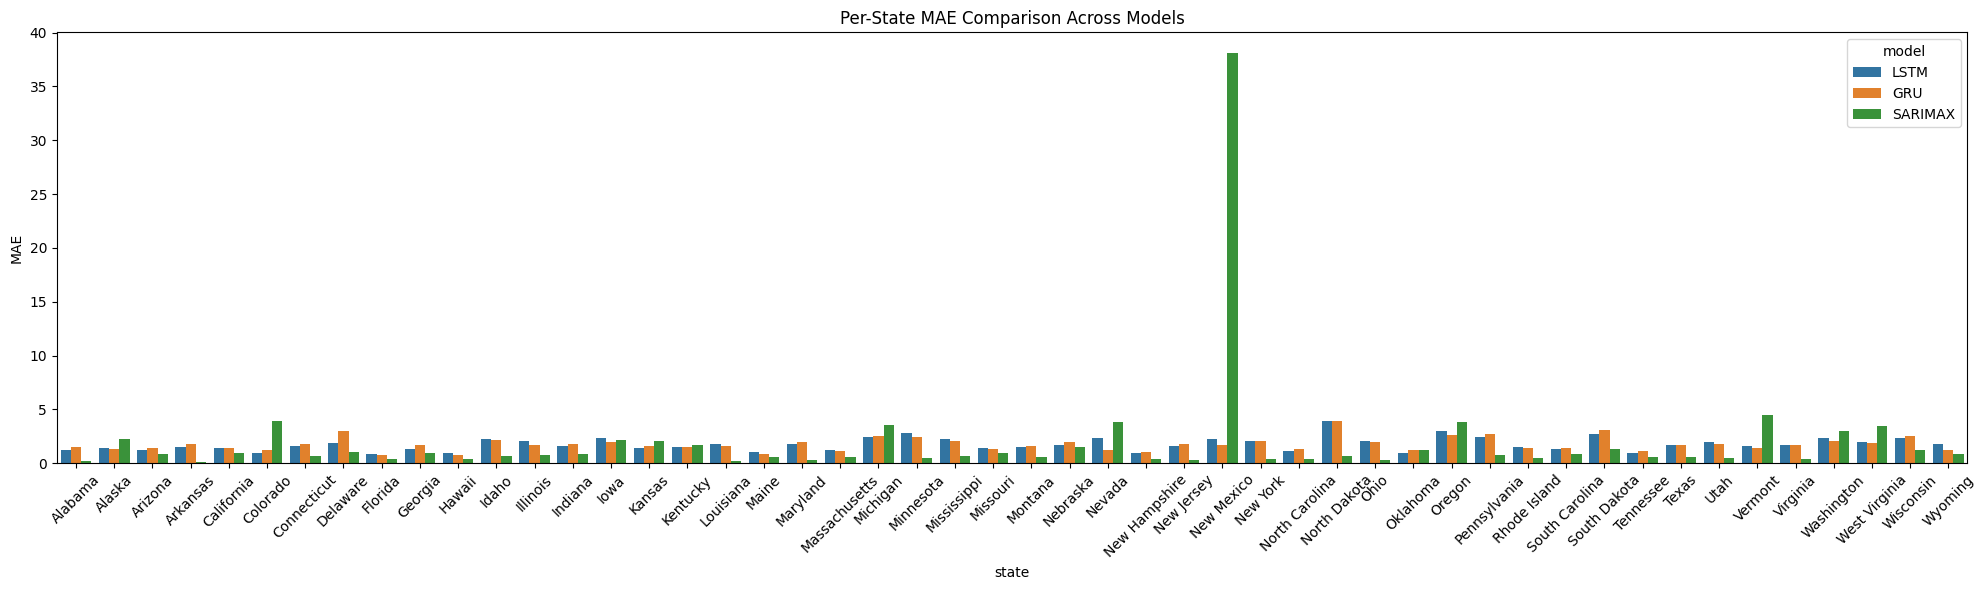

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 6))
sns.barplot(data=all_results, x="state", y="MAE", hue="model")
plt.title("Per-State MAE Comparison Across Models")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

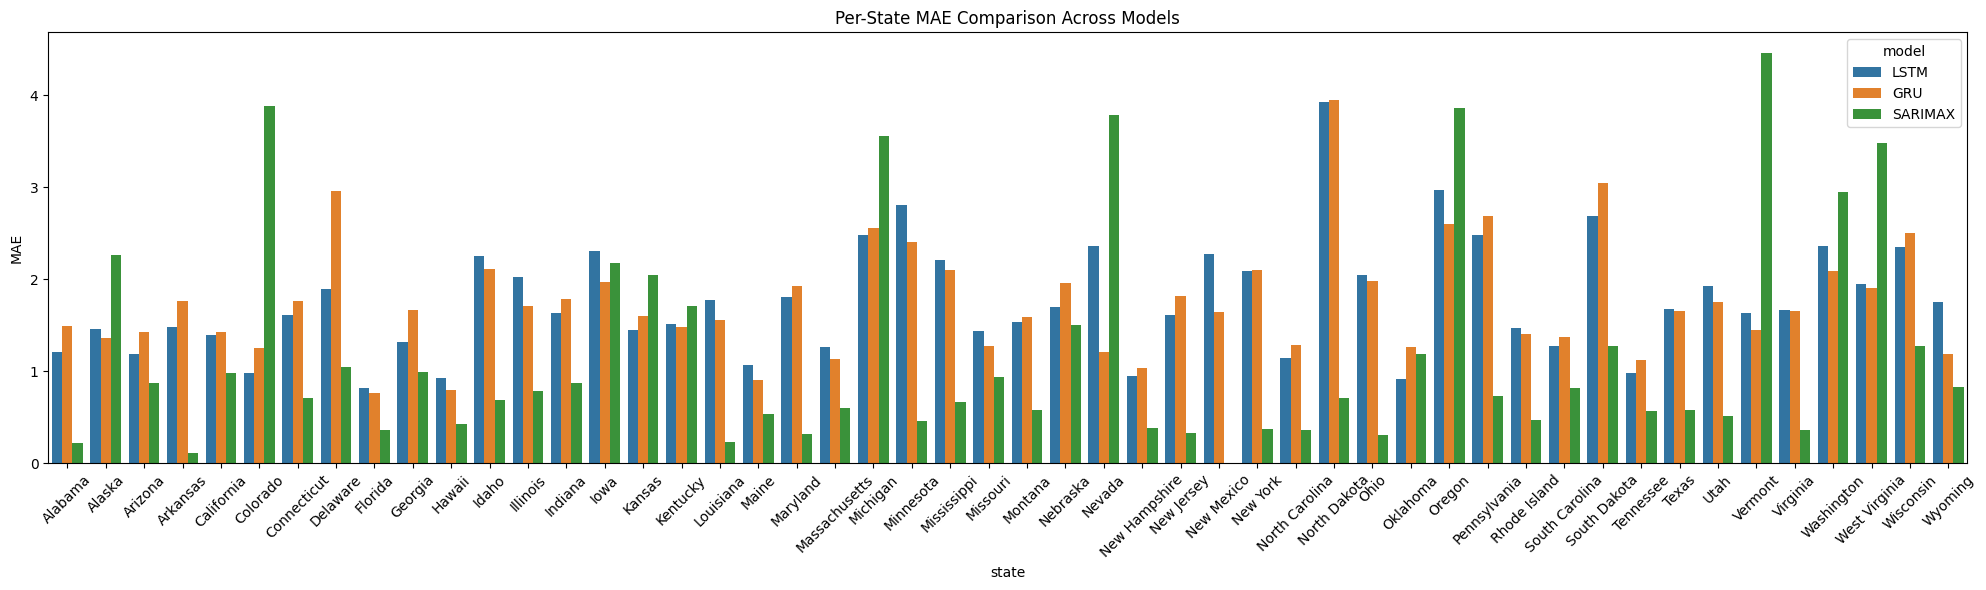

In [51]:
# Remove 'New Mexico' from the SARIMAX metrics DataFrame due to really high MAE value
sarimax_metrics = sarimax_metrics[sarimax_metrics['state'] != 'New Mexico'].copy()

all_results = pd.concat([lstm_metrics, gru_metrics, sarimax_metrics], ignore_index=True)

plt.figure(figsize=(20, 6))
sns.barplot(data=all_results, x="state", y="MAE", hue="model")
plt.title("Per-State MAE Comparison Across Models")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

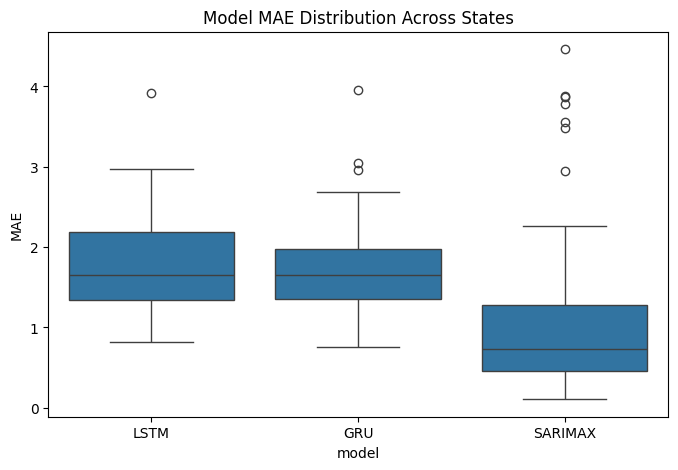

In [52]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=all_results, x="model", y="MAE")
plt.title("Model MAE Distribution Across States")
plt.show()
